In [52]:
import sys
sys.path.append("../")
from matplotlib import pyplot as plt
from matplotlib.axes import Axes
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from axessettings import AxesSetting, linear_sim

In [53]:
I_static = lambda V_DS, V_0, R_L:(V_0 - V_DS) / R_L

In [54]:
V_GS = [0.0, 0.4, 0.8, 1.2, 1.6, 2.0, 2.4]
datas = pd.read_excel("data.xlsx", sheet_name=[f"(2)-{v:.2f}" for v in V_GS], skiprows=[1])
for v in V_GS:
    datas[v] = datas.pop(f"(2)-{v:.2f}")
    datas[v].sort_values(by="V_DS", axis=0, inplace=True, ascending=True)
    if v >= 1.2:
        datas[v].loc[:, "I_D"] *= 1e-6
    else:
        datas[v].loc[:, "I_D"] *= 1e-3

data_static = pd.read_excel("data.xlsx", sheet_name="(3)", skiprows=[0, 2], header=[0])

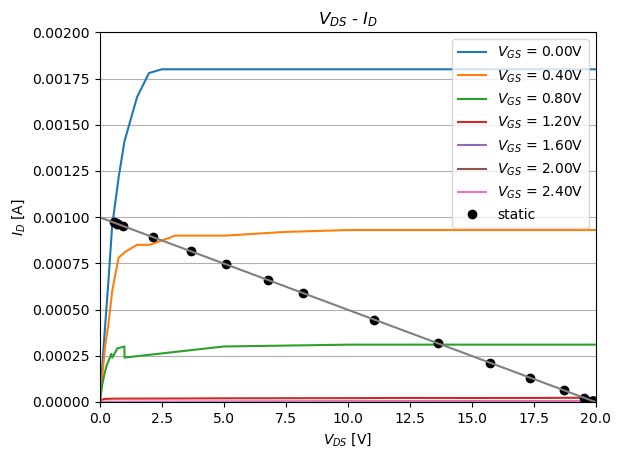

In [55]:
V_0 = 19.98
R_L = 20e3

fig = plt.figure()
ax = fig.add_subplot(111)

axessetting = AxesSetting(legend=True, xlabel="$V_{DS}$ [V]", grid="y", ylabel="$I_D$ [A]", title="$V_{DS}$ - $I_D$", xlim=(0, 20), ylim=(0, 0.002))
for v in V_GS:
    ax.plot(datas[v]["V_DS"], datas[v]["I_D"], label=f"$V_{{GS}}$ = {v:.2f}V")

ax.plot(data_static["V_DS"], (V_0-data_static["V_DS"])/R_L, label="static", marker="o", linestyle="None", c="black")

axessetting.plot_func(ax, lambda vds: I_static(vds, V_0, R_L))
axessetting.apply_axes(ax)

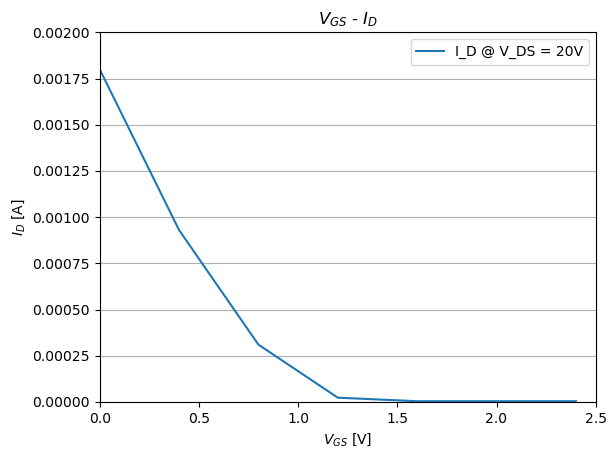

In [56]:
fig = plt.figure()
ax = fig.add_subplot(111)

axessetting = AxesSetting(legend=True, xlabel="$V_{GS}$ [V]", grid="y", ylabel="$I_D$ [A]", title="$V_{GS}$ - $I_D$", xlim=(0, 2.5), ylim=(0, 0.002))

ax.plot([v for v in V_GS], [datas[v].iloc[-1]["I_D"] for v in V_GS], label="I_D @ V_DS = 20V")

axessetting.apply_axes(ax)